In [1]:
import healpy as hp
import numpy as np
import pylab as pl
import camb 
rot = hp.Rotator(coord=['C','G'])

# Masks employed in this work

In [2]:
binmask_c = hp.read_map('mask_qso_binary_mcs_dust_Av0.2_NSIDE256.fits')
mask_c = hp.read_map('mask_qso_prob_NSIDE256.fits')
lensmask = hp.read_map('/Users/fabbian/Work/Planck/DR3/COM_Lensing-CIBcomb_2000_R3.00/inputs/mask.fits')

/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 256
  warnings.warn("NSIDE = {0:d}".format(nside))
/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))
/Use

I rotate the GAIA mask in Galactic coordinates as all Planck masks are defined in Galactic coordinates and in the analysis of real data everything should be in Galactic coordinates for consistency.

NOTE: you could define/rotate the Planck data products in Celestial coordinates instead. For the masks you can follow the same approach/functions I used here. For the harmonic coefficients $\kappa_{\ell m}$ you should use the `rotate_alm function` of healpy which is however slow for high values of $\ell_{max}$

In [3]:
mask = rot.rotate_map_pixel(mask_c)
binmask = rot.rotate_map_pixel(binmask_c)

# here I upgrade the resolution of the binary mask to match the native one of Planck just for plotting purposes.
binmask_hr = hp.ud_grade(binmask,nside_out=2048)

Here I read some of the Planck galactic masks that you can retrieve from the Planck legavy archive. They are
useful to check what happens using smoother masks compared to the ones derived from the GAIA data. 

NOTE: the Planck lensing masks is roughly the Planck Galactic mask retaining 60% of the sky plus some point sources  masks removing IR/Radio galaxies or Galaxy clusters.

In [4]:
galmask40 = hp.read_map('/Users/fabbian/Work/YxWxSCOSMOS/data/masks/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=1)
galmask = hp.read_map('/Users/fabbian/Work/YxWxSCOSMOS/data/masks/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=2)

/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/healpy/fitsfunc.py:426: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))
/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/healpy/fitsfunc.py:486: UserWarning: Ordering converted to RING
  warnings.warn("Ordering converted to RING")


/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally regis

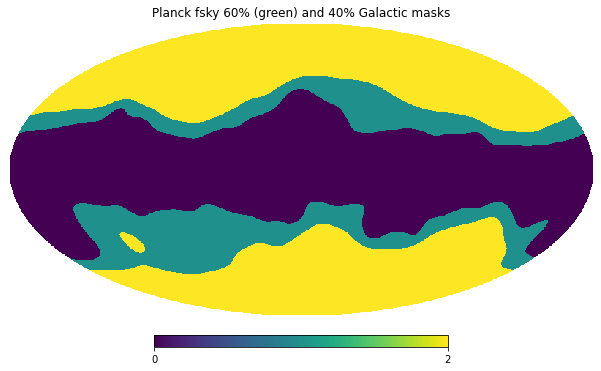

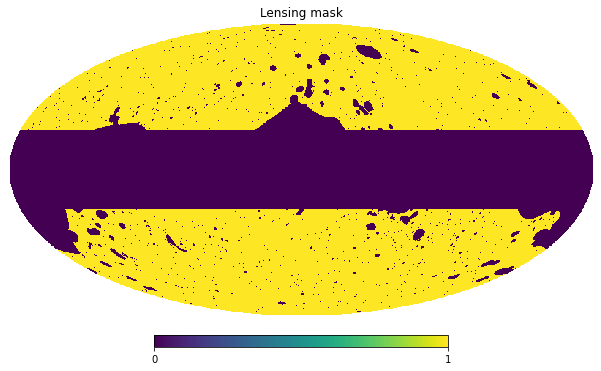

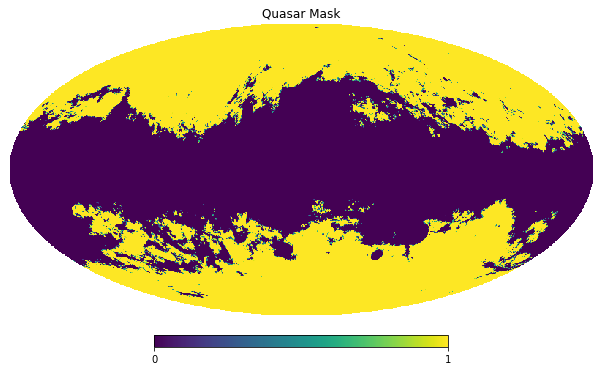

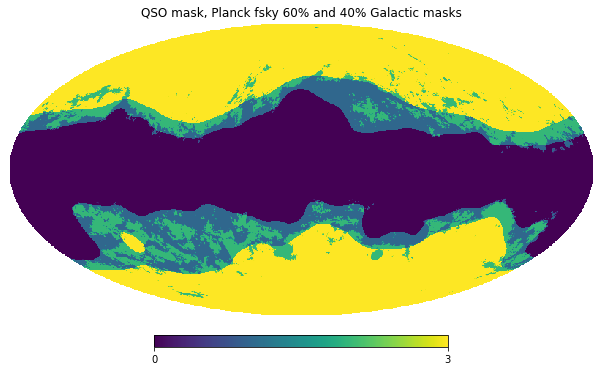

In [5]:
hp.mollview(galmask+galmask40,title='Planck fsky 60% (green) and 40% Galactic masks')
hp.mollview(lensmask,title='Lensing mask')
hp.mollview(binmask_hr,title='Quasar Mask')
hp.mollview(binmask_hr+galmask+galmask40,title='QSO mask, Planck fsky 60% and 40% Galactic masks')

From this last plot we can see that the Planck 40% mask removes an additional significant fraction in the southern
hemisphere, while a minimal part of the northern part. If we see problems with the QSO mask on data we might 
consider either using those to test stability of the result or multiply the QSO mask for the Planck 40% mask in
the northern Galactic hemisphere and keep the Planck 60% sky in the southern Galactic hempishere.

The lensing mask essentially removes mainly point sources compared to the QSO mask as the galactic cut is similar.

# CAMB theory curve

Here I compute the CAMB theory curves starting from the Gaia $dN/dz$ including all the expected terms that model the counts.

In [6]:
# read dn/dz and normalize it
dndz=np.loadtxt('dndz_G20.0.dat',unpack=True,delimiter=',')
dndz = [(dndz[0]+dndz[1])/2,dndz[2]]
dndz[1]/=np.trapz(dndz[1],dndz[0])

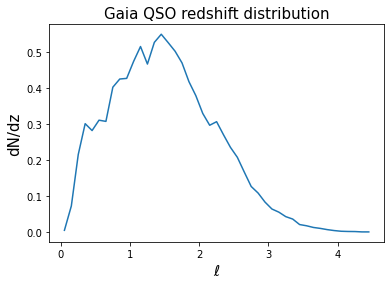

In [7]:
pl.plot(dndz[0],dndz[1])
pl.ylabel("dN/dz",size=15)
pl.xlabel("$\ell$",size=15)
pl.title("Gaia QSO redshift distribution",size=15)
pl.show()

In [8]:
import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
pars = camb.CAMBparams()
lmax=4000
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0)
pars.InitPower.set_params(As=2e-9, ns=0.965)
pars.set_for_lmax(lmax, lens_potential_accuracy=4)
##set Want_CMB to true if you also want CMB spectra or correlations
pars.Want_CMB = True

##NonLinear_both or NonLinear_lens will use non-linear corrections
pars.NonLinear = model.NonLinear_both


#density only is the default
pars.SourceTerms.limber_windows = True
pars.SourceTerms.limber_phi_lmin = 200
pars.SourceTerms.counts_lensing = True
pars.SourceTerms.counts_density  = True
pars.SourceTerms.counts_redshift = True #weird problems at times
pars.SourceTerms.counts_radial   = True # negligible at l<10
pars.SourceTerms.counts_timedelay = True # negligible
pars.SourceTerms.counts_ISW = True #negligible
pars.SourceTerms.counts_velocity = True #negligible
pars.SourceTerms.counts_potential = True #negligible

##Set up W(z) window functions, later labelled W1 from Gaia dN/dz function.
W=np.array(dndz[1])
z=np.array(dndz[0])
pars.SourceWindows = [SplinedSourceWindow(bias_z=2.35, z=z, W=W,source_type='counts')]

results = camb.get_results(pars)

# In the returned dictionary P is the lensing potential and not deflection as in camb doc if raw_cl=True. 
# potentially related to CAMB version and fixed in later ones?
cmb = results.get_cmb_power_spectra(raw_cl=True,CMB_unit='muK')
cls = results.get_source_cls_dict(raw_cl=True) 


/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


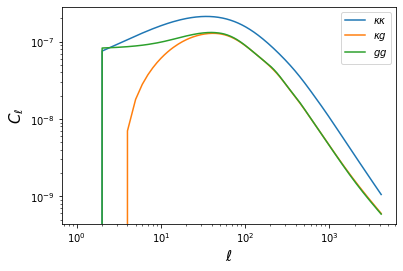

/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


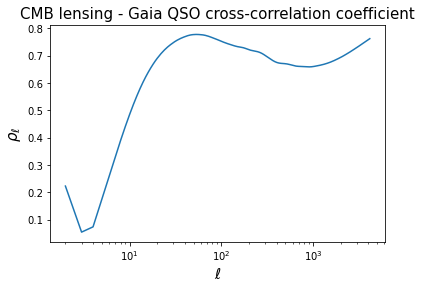

In [11]:
# plots power spectra
ls = np.arange(len(cls['PxP']))
p2d=np.sqrt(ls*(ls+1))
d2p=1/p2d
d2p[0:2]=0.0
d2k=p2d/2
p2k=(p2d**2/2)

pl.loglog(ls,cls['PxP']*p2k**2,label='$\kappa\kappa$')
pl.loglog(ls,cls['PxW1']*p2k,label='$\kappa g$') # should give kappaX for cross correlation
pl.loglog(ls,cls['W1xW1'],label='$gg$') 
pl.xlabel("$\ell$",size=15)
pl.ylabel("$C_\ell$",size=15)
pl.legend()
pl.show()

rho = cls['PxW1']*p2k/np.sqrt(np.abs(cls['PxP']*(p2k**2)*cls['W1xW1']))
pl.semilogx(ls,np.abs(rho))
pl.xlabel("$\ell$",size=15)
pl.ylabel("$\\rho_\ell$",size=15)
pl.title("CMB lensing - Gaia QSO cross-correlation coefficient",size=15)
pl.show()

Here I check the definition / self consistency of the power spectra I got from CAMB from different outputs.

In [12]:
dls = results.get_source_cls_dict(raw_cl=False)
cmbdl = results.get_cmb_power_spectra(raw_cl=False,CMB_unit='muK')
uldl= results.get_cmb_unlensed_scalar_array_dict()
ulcl= results.get_cmb_unlensed_scalar_array_dict(raw_cl=True)

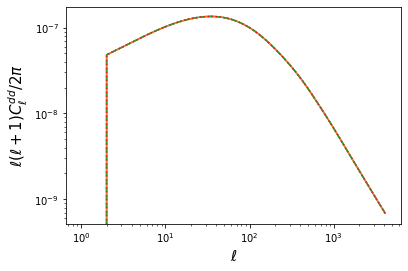

/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


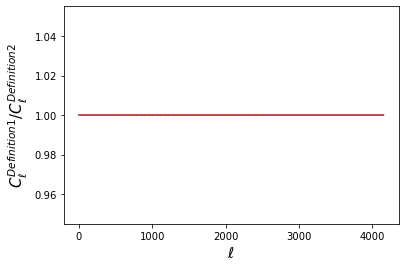

In [13]:
#print(len(ls),len(cmb['lens_potential'].T[0]),len(d2k))
cl2dl=ls*(ls+1)/2/np.pi
pl.loglog(ls[:4051],(cmb['lens_potential'].T[0])*(p2d[:4051]**2)*cl2dl[:4051])
pl.loglog(ls[:4051],(cmbdl['lens_potential'].T[0]))
pl.loglog(ls,dls['PxP'],ls='--')
pl.loglog(ls,cls['PxP']*(p2d**2)*cl2dl,ls=':')
pl.ylabel("$\ell(\ell+1)C_\ell^{dd}/2\pi$",size=15)
pl.xlabel("$\ell$",size=15)
pl.show()

# plot below should all be 1
pl.plot(ls,dls['W1xW1']/cls['W1xW1']/cl2dl,ls='-')
pl.plot(ls,dls['PxW1']/cl2dl/(cls['PxW1']*p2d),ls='-')
pl.plot(ls,uldl['PxW1']/cl2dl/(cls['PxW1']*p2d),ls=':')
pl.plot(ls,uldl['PxW1']/(ulcl['PxW1']*cl2dl*p2d),ls='-')
pl.plot(ls,ulcl['PxW1']/cls['PxW1'],ls=':')
pl.ylabel("$C_\ell^{Definition1}/C_\ell^{Definition2}$",size=15)
pl.xlabel("$\ell$",size=15)
pl.show()

# Power spectrum tests

I use 0.5 deg apodization for the QSO mask and and 1 deg for the Planck 60% Galactic mask. I use those as test 
cases and also the QSO mask including the weighting that I apodize with the same apodization as of the QSO binary
mask (basically the product of the two).

Once I apodize the map I initialize the structure needed for the power spectrum and compute the coupling matrices 
that I will use in the MC tests. I just need to do this once per mask.

In [14]:
import pymaster as nmt

In [15]:
# HEALPix map resolution
nside = 256
binmask[binmask!=0]=1
apomask = nmt.mask_apodization(binmask,0.5, apotype="C2")
apomask_gal = nmt.mask_apodization(hp.ud_grade(galmask,nside_out=256),1, apotype="C2")

# b) Generates fake data to initialize the power spectrum and field structures. I convert the spectra to kg
clpp = np.abs(cls['PxW1']*p2k) 
clpp[:2]=0.
mp_t = hp.synfast(clpp,nside=nside)

# binning in multipole space, should have a prefactor that makes cls relatively constant. Cl^kg is the one with 
# less important trends in \ell. I bin in Cl but you can use i.e. cls['PxW1'] and set is_Dell= True that applies
# l(l+1)/2pi prefactor before binning and returns D_l = l(l+1)/2pi*C_
b = nmt.NmtBin.from_nside_linear(nside, 20,is_Dell=False)

# here below I define different Cl coupling matrix with different masks.
f0 = nmt.NmtField(apomask, [mp_t])
w = nmt.NmtWorkspace()
w.compute_coupling_matrix(f0, f0, b)

f0 = nmt.NmtField(apomask_gal, [mp_t])
w60 = nmt.NmtWorkspace()
w60.compute_coupling_matrix(f0, f0, b)

f0 = nmt.NmtField(apomask*mask, [mp_t])
ww = nmt.NmtWorkspace()
ww.compute_coupling_matrix(f0, f0, b)

def compute_master(f_a, f_b, wsp):
    # Compute the power spectrum (a la anafast) of the masked fields
    # Note that we only use n_iter=0 here to speed up the computation,
    # but the default value of 3 is recommended in general.
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    # Decouple power spectrum into bandpowers inverting the coupling matrix
    cl_decoupled = wsp.decouple_cell(cl_coupled)
    return cl_decoupled
    

/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/healpy/sphtfunc.py:438: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,
/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally regis

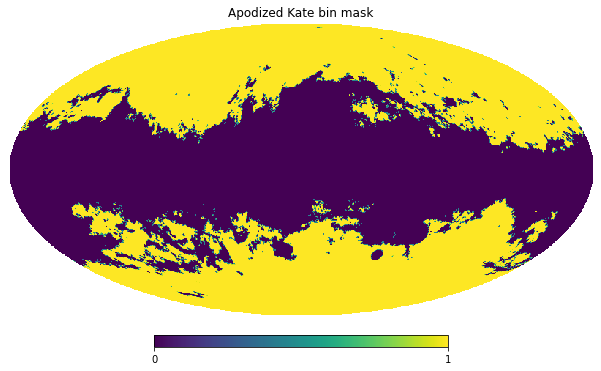

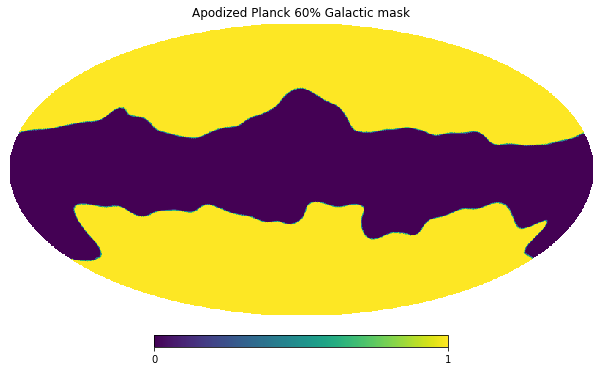

In [16]:
hp.mollview(apomask,title='Apodized Kate bin mask',min=0,max=1)
hp.mollview(apomask_gal,title='Apodized Planck 60% Galactic mask',min=0,max=1)

## Simple MC from $C_\ell^{kg}$

I generate MC realizations of a scalar field with power spectrum $C_\ell^{kg}$ and check that the recovered spectrum is consistent with the theory i.e. unbiased

In [17]:
nsim = 20
clth = np.abs(cls['PxW1']*p2k)
null_cl = np.zeros_like(cls['PxW1'])

cl_mean = np.zeros(38)
cl_std = np.zeros_like(cl_mean)

cl_mean_w = np.zeros(38)
cl_std_w = np.zeros_like(cl_mean)

cl_mean_gal = np.zeros(38)
cl_std_gal = np.zeros_like(cl_mean)

for i in np.arange(nsim):
    
    t= hp.synfast(clth, nside, verbose=False)
    
    f0_sim = nmt.NmtField(apomask, [t])
    f0_sim_gal = nmt.NmtField(apomask_gal, [t])
    f0_sim_w = nmt.NmtField(apomask*mask, [t])
    
    cl = compute_master(f0_sim, f0_sim, w)[0]
    cl_w = compute_master(f0_sim_w, f0_sim_w, ww)[0]    
    cl_gal = compute_master(f0_sim_gal, f0_sim_gal, w60)[0]    
    
    cl_mean += cl
    cl_std += cl*cl
    
    cl_mean_w += cl_w
    cl_std_w += cl_w*cl_w    
    
    cl_mean_gal += cl_gal
    cl_std_gal += cl_gal*cl_gal    
    
cl_mean /= nsim
cl_std = np.sqrt(cl_std / nsim - cl_mean*cl_mean)

cl_mean_w /= nsim
cl_std_w = np.sqrt(cl_std_w / nsim - cl_mean_w*cl_mean_w)

cl_mean_gal /= nsim
cl_std_gal = np.sqrt(cl_std_gal / nsim - cl_mean_gal*cl_mean_gal)

cl_th_binned = w.decouple_cell(w.couple_cell([clth]))

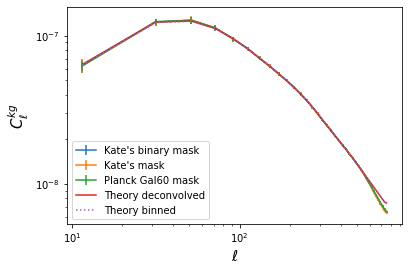

In [18]:
lb = b.get_effective_ells()
norm=1#lb*(lb+1)/2/np.pi
clb = b.bin_cell(clth[:3*nside])
pl.errorbar(lb,norm*cl_mean,norm*cl_std,label="Kate's binary mask")
pl.errorbar(lb,norm*cl_mean_w,norm*cl_std,label="Kate's mask")
pl.errorbar(lb,norm*cl_mean_gal,norm*cl_std_gal,label="Planck Gal60 mask")
pl.errorbar(lb,norm*cl_th_binned[0],label="Theory deconvolved") #includes coupling effects of the mask
pl.errorbar(lb,norm*clb,ls=':',label="Theory binned")
pl.xscale('log')
pl.yscale('log')
pl.xlabel("$\ell$",size=15)
pl.ylabel("$C^{kg}_\ell$",size=15)
pl.legend()
pl.show()

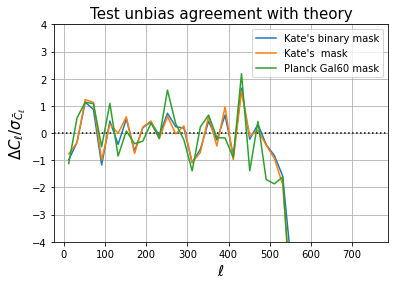

In [19]:
cl_th_binned = w.decouple_cell(w.couple_cell([clth]))
cl_th_binned_gal = w60.decouple_cell(w60.couple_cell([clth]))
cl_th_binned_w = ww.decouple_cell(ww.couple_cell([clth]))

pl.errorbar(lb,(cl_mean-cl_th_binned[0])/(cl_std/np.sqrt(nsim)),label="Kate's binary mask")
pl.errorbar(lb,(cl_mean_w-cl_th_binned_w[0])/(cl_std_w/np.sqrt(nsim)),label="Kate's  mask")
pl.errorbar(lb,(cl_mean_gal-cl_th_binned_gal[0])/(cl_std_gal/np.sqrt(nsim)),label="Planck Gal60 mask")
pl.axhline(0,color='k',ls=':')
pl.xlabel("$\ell$",size=15)
pl.ylabel("$\Delta C_\ell/\sigma_{\\bar{C}_\ell}$",size=15)
pl.ylim(-4,4)
pl.grid()
pl.title('Test unbias agreement with theory',size=15)
pl.legend()
pl.show()

## Correlated Gaussian fields MC

Here I generate correlated realization of CMB $\kappa$ and quasar field $g$ and analyze the same maps with different masks for the auto spectra $C_\ell^{\kappa\kappa}, C_\ell^{gg}$ and $C_\ell^{\kappa g}$

In [20]:
nsim = 20

cl_mean = np.zeros((3,38))
cl_std = np.zeros_like(cl_mean)

cl_mean_w = np.zeros((3,38))
cl_std_w = np.zeros_like(cl_mean)

cl_mean_gal = np.zeros((3,38))
cl_std_gal = np.zeros_like(cl_mean)

cls_id = np.ones(3*nside)
cls_id[0:2]=0.0

for i in np.arange(nsim):

    alms_g1 = hp.synalm(cls_id,lmax=3*nside-1)
    alms_g2 = hp.synalm(cls_id,lmax=3*nside-1)
    
    alms_k = hp.almxfl(alms_g1,np.sqrt(cls['PxP']*p2k**2))
    f1 = cls['PxW1']*p2k/np.sqrt(cls['PxP']*p2k**2)
    f2 = np.sqrt(cls['W1xW1']-f1**2)
    f1[f1!=f1]=0.
    f2[f2!=f2]=0.
    alms_g = hp.almxfl(alms_g1,f1)+hp.almxfl(alms_g2,f2)
   
    k,g = hp.alm2map([alms_k,alms_g],nside=nside,pol=False,lmax=3*nside-1) 
    
    f0_sim = nmt.NmtField(apomask, [k])
    f0_sim_gal = nmt.NmtField(apomask_gal, [k])
    f0_sim_w = nmt.NmtField(apomask*mask, [k])
    
    f0_sim_g = nmt.NmtField(apomask, [g])
    f0_sim_gal_g = nmt.NmtField(apomask_gal, [g])
    f0_sim_w_g = nmt.NmtField(apomask*mask, [g])    
    
    cl = np.array([compute_master(f0_sim, f0_sim, w)[0], compute_master(f0_sim_g, f0_sim_g, w)[0],
        compute_master(f0_sim, f0_sim_g, w)[0]])
    
    cl_w =np.array( [compute_master(f0_sim_w, f0_sim_w, ww)[0], compute_master(f0_sim_w_g, f0_sim_w_g, ww)[0],
        compute_master(f0_sim_w, f0_sim_w_g, ww)[0]])
    
    cl_gal =np.array( [compute_master(f0_sim_gal, f0_sim_gal, w60)[0], compute_master(f0_sim_gal_g, f0_sim_gal_g, w60)[0],
        compute_master(f0_sim_gal, f0_sim_gal_g, w60)[0]])
        
    cl_mean += cl
    cl_std += cl*cl
    
    cl_mean_w += cl_w
    cl_std_w += cl_w*cl_w    
    
    cl_mean_gal += cl_gal
    cl_std_gal += cl_gal*cl_gal    
    
    
cl_mean /= nsim
cl_std = np.sqrt(cl_std / nsim - cl_mean*cl_mean)

cl_mean_w /= nsim
cl_std_w = np.sqrt(cl_std_w / nsim - cl_mean_w*cl_mean_w)

cl_mean_gal /= nsim
cl_std_gal = np.sqrt(cl_std_gal / nsim - cl_mean_gal*cl_mean_gal)


/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


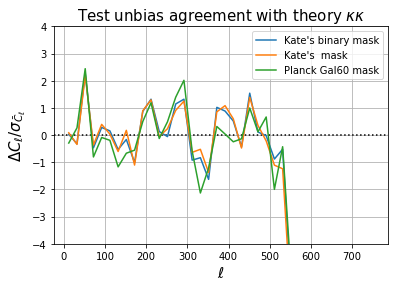

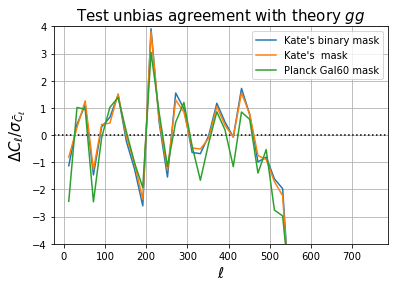

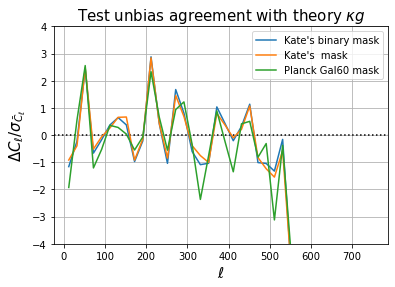

In [21]:
#clth = np.abs(cls['PxW1']*p2k)
#clth = np.abs(cls['PxP']*p2k**2)

lb = b.get_effective_ells()
cls_mc = [cls['PxP']*p2k**2,cls['W1xW1'],cls['PxW1']*p2k]

cl_th_binned = [w.decouple_cell(w.couple_cell([i]))[0] for i in cls_mc]
cl_th_binned_gal = [w60.decouple_cell(w60.couple_cell([i]))[0] for i in cls_mc]
cl_th_binned_w = [ww.decouple_cell(ww.couple_cell([i]))[0] for i in cls_mc]

labels =['$\kappa\kappa$','$gg$','$\kappa g$']

for i in range(3):
    #print(len(lb),len(cl_mean[i]),len(cl_th_binned[i]))
    pl.errorbar(lb,(cl_mean[i]-cl_th_binned[i])/(cl_std[i]/np.sqrt(nsim)),label="Kate's binary mask")
    pl.errorbar(lb,(cl_mean_w[i]-cl_th_binned_w[i])/(cl_std_w[i]/np.sqrt(nsim)),label="Kate's  mask")
    pl.errorbar(lb,(cl_mean_gal[i]-cl_th_binned_gal[i])/(cl_std_gal[i]/np.sqrt(nsim)),label="Planck Gal60 mask")
    pl.axhline(0,color='k',ls=':')
    pl.xlabel("$\ell$",size=15)
    pl.ylabel("$\Delta C_\ell/\sigma_{\\bar{C}_\ell}$",size=15)
    pl.ylim(-4,4)
    pl.grid()
    pl.title('Test unbias agreement with theory %s'%labels[i],size=15)
    pl.legend()
    pl.show()

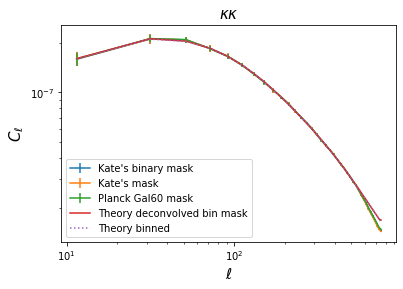

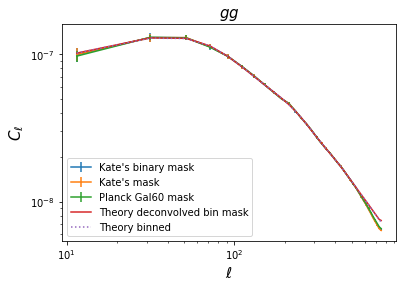

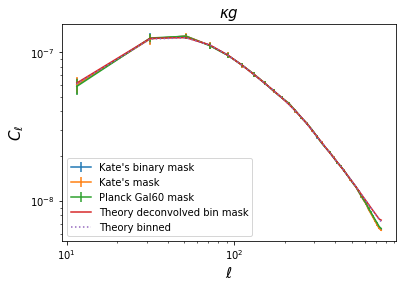

In [22]:
lb = b.get_effective_ells()
norm=1#lb*(lb+1)/2/np.pi
for i in range(3):
    clb = b.bin_cell(cls_mc[i][:3*nside])
    pl.errorbar(lb,norm*cl_mean[i],norm*cl_std[i],label="Kate's binary mask")
    pl.errorbar(lb,norm*cl_mean_w[i],norm*cl_std[i],label="Kate's mask")
    pl.errorbar(lb,norm*cl_mean_gal[i],norm*cl_std_gal[i],label="Planck Gal60 mask")
    pl.errorbar(lb,norm*cl_th_binned[i],label="Theory deconvolved bin mask") #includes coupling effects of the mask
    pl.errorbar(lb,norm*clb,ls=':',label="Theory binned")
    pl.xscale('log')
    pl.yscale('log')
    pl.xlabel("$\ell$",size=15)
    pl.ylabel("$C_\ell$",size=15)
    pl.title("%s"%labels[i],size=15)    
    pl.legend()
    pl.show()

# Summary 

The tests seem to undicate the pipeline should be unbiased till about $\ell_{max}\approx 2 nside =512$. We do not see major biases per bin at more than 2$\sigma$ compared to the Monte Carlo expectations. We could fine tune some setups to improve things further on data if we increase the $\ell_{max}$ or the resolution of the maps. The CAMB calculation also show we should be able to see a
high degree of correlations between the lensing field and the QSO catalog.